<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Define-Functions" data-toc-modified-id="Define-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Functions</a></span><ul class="toc-item"><li><span><a href="#Visualization" data-toc-modified-id="Visualization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#def-plotTimeSeries()" data-toc-modified-id="def-plotTimeSeries()-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span><code>def plotTimeSeries()</code></a></span></li></ul></li><li><span><a href="#Find-window-size" data-toc-modified-id="Find-window-size-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Find window size</a></span><ul class="toc-item"><li><span><a href="#def-findDominantFreq():---Find-the-freq-with-strongest-strength-in-Periodogram" data-toc-modified-id="def-findDominantFreq():---Find-the-freq-with-strongest-strength-in-Periodogram-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span><code>def findDominantFreq():</code> - Find the freq with strongest strength in Periodogram</a></span></li><li><span><a href="#def-findAutoPeriod()---Find-the-period-of-the-time-series-data" data-toc-modified-id="def-findAutoPeriod()---Find-the-period-of-the-time-series-data-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span><code>def findAutoPeriod()</code> - Find the period of the time series data</a></span></li></ul></li><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#def-normalize(df):" data-toc-modified-id="def-normalize(df):-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span><code>def normalize(df):</code></a></span></li></ul></li><li><span><a href="#Discretize-the-Time-series-data-by-sliding-window" data-toc-modified-id="Discretize-the-Time-series-data-by-sliding-window-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Discretize the Time series data by sliding window</a></span><ul class="toc-item"><li><span><a href="#def-createSequences(values,-time_steps=100):" data-toc-modified-id="def-createSequences(values,-time_steps=100):-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span><code>def createSequences(values, time_steps=100):</code></a></span></li></ul></li><li><span><a href="#Build-&amp;-Train-model" data-toc-modified-id="Build-&amp;-Train-model-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Build &amp; Train model</a></span><ul class="toc-item"><li><span><a href="#def-buildAutoencoder(train_df,-model_name,-folder):" data-toc-modified-id="def-buildAutoencoder(train_df,-model_name,-folder):-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span><code>def buildAutoencoder(train_df, model_name, folder):</code></a></span></li><li><span><a href="#def-saveAutoencoder(model_name,-folder):" data-toc-modified-id="def-saveAutoencoder(model_name,-folder):-2.5.2"><span class="toc-item-num">2.5.2&nbsp;&nbsp;</span><code>def saveAutoencoder(model_name, folder):</code></a></span></li><li><span><a href="#def-trainAutoencoder(x_train,-model):" data-toc-modified-id="def-trainAutoencoder(x_train,-model):-2.5.3"><span class="toc-item-num">2.5.3&nbsp;&nbsp;</span><code>def trainAutoencoder(x_train, model):</code></a></span></li></ul></li></ul></li><li><span><a href="#Main" data-toc-modified-id="Main-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Build,-Train-and-Test-Autoencoder-for-all-data" data-toc-modified-id="Build,-Train-and-Test-Autoencoder-for-all-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Build, Train and Test Autoencoder for all data</a></span></li></ul></li></ul></div>

Reference
    
https://keras.io/examples/timeseries/timeseries_anomaly_detection/

# Setup

In [30]:
import os
from typing import Iterable

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import scipy.signal as signal
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

from tensorflow import keras
from tensorflow.keras import layers

from loadData import DataLoader


# Define Functions

## Visualization

### `def plotTimeSeries()`

In [22]:
def plotTimeSeries(df, figsize_n: int = 80, figsize_m: int = 6, title='', title_fontsize=60):
#     N, M = 80, 6
    fig, ax = plt.subplots(figsize=(figsize_n, figsize_m))
    df.plot(legend=False, ax=ax)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

## Find window size

http://www.l3s.de/~anand/tir14/lectures/ws14-tir-foundations-2.pdf

Steps to identify `Auto-Period` (i.e. values of x-axis time `t` that the time series signal repeats itself):
1. Find the dominant frequency by the highest "power at that freq" using "Power Spectral Density (PSD) Estimation" in the Periodogram
    p.s. Periodogram encodes the strength at a given frequency
2. Use candidate periods from Periodogram, and validate false alarms using Auto-correlation

<img src="../img/periodogram+autocorrelation.png">

### `def findDominantFreq():` - Find the freq with strongest strength in Periodogram

In [29]:
def findDominantFreq(x) -> Iterable[Iterable]:
    '''
    Parameters
    ----------
    x : array_like
        Time series of measurement values
        
    Return
    ----------
    dominant_freq_ls: array_like
                      Array of sample frequencies.
    Pxx_den_ls: array_like
                Power spectral density or power spectrum of `x`.
    '''
    dominant_freq_ls = [] # 
    Pxx_den_ls = [] #Power spectral density or power spectrum of `x`.
    
    for i in range(len(fn)):
        f, Pxx_den = signal.periodogram(x, fs)
        dominant_freq_ls.append(f[1:]) # skip the first dominant freq, 
        Pxx_den_ls.append(p[1:])       # mention in the .pdf

    return dominant_freq_ls, Pxx_den_ls

### `def findAutoPeriod()` - Find the period of the time series data

In [28]:
def findAutoPeriod():
    '''Find the period of the time series data by (1) Periodogram and (2) Auto-correlation
    
    Steps
    ---
    1. Find the dominant frequency by the highest "power at that freq" using "Power Spectral Density (PSD) Estimation" in the Periodogram
    2. Use candidate periods from Periodogram, and validate false alarms using Auto-correlation
    
    P.S. Periodogram encodes the strength at a given frequency
    '''
    periodicity = []
    
    df = pd.DataFrame({'freq': freq[i] , 'PSD' : Pxx_den[i] , 'Period' : 1/freq[i]})
    periodicity.append(df)

    color=['r','b','g','k','c']
    hints=[]  #Period hints capture from periodogram
    
    df = periodicity[i]
    hints.append(list(round(df[(df["Period"]>=10)].sort_values('PSD',ascending=False)[:5]['Period'])))
    #print(hints)
        #plot_acf(data[j],lags = 1000)
    acf_record = []

    acf_record.append(acf(data[j],nlags=max(hints[j]),fft =True))
    #plt.plot(x,marker="|")
    #for k in range(len(hints[j])):
    #    plt.axvline(x=hints[j][k],color=color[k])
    #plt.show()
        
    autoperiod=[]
    
    #print(fn[i])
    temp = acf_record[i][[int(h) for h in hints[i]]]
    autoperiod.append(hints[i][np.array(temp).argmax()])



## Prepare Data

### `def normalize(df):`

In [13]:
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    '''Normalize data by the mean and std.
    Return the normalized data value
    '''
    
    _mean = df.mean()
    _std = df.std()
    df_value = (df - _mean) / _std

#     print("Number of samples:", len(df_value))

#     display(df)

#     display(df_value)

    display(df.describe())

    df_value.describe()

    return df_value

## Discretize the Time series data by sliding window

### `def createSequences(values, time_steps=100):`

In [4]:
def createSequences(values, time_steps=100):
    '''Generated training sequences for use in the model.
    '''
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

## Build & Train model

### `def buildAutoencoder(train_df, model_name, folder):`

In [6]:
def buildAutoencoder(shape: tuple,
                     learning_rate=0.01,
                    ):
    model = keras.Sequential(
        [
            layers.Input(shape=(train_df.shape[1], train_df.shape[2])),
            layers.Conv1D(filters=16, kernel_size=4, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=0.2),
            layers.Conv1D(filters=8, kernel_size=4, padding="same", strides=2, activation="relu"),
            layers.Conv1DTranspose(filters=8, kernel_size=4, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(filters=16, kernel_size=4, padding="same", strides=2, activation="relu"),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
#     model.summary()

    return model

### `def saveAutoencoder(model_name, folder):`

In [8]:
def saveAutoencoder(model_name: str = '',
                    folder: str = 'models/autoencoder',
                   ):
    if not os.path.exists(folder):
        os.makedirs(folder)
    path = f'{folder}/{model_name+".h5"}'
    model.save(path)
    print(f'Saved `{path}` !')

### `def trainAutoencoder(x_train, model):`


In [ ]:
def trainAutoencoder(discretized_X, model):
    history = model.fit(
        discretized_X,  # x_train_padded_zero,
        discretized_X,  # x_train_padded_zero,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=5, mode="min")
        ],
    )
    
    return model, history

# Main

## Load data

In [9]:
path = '../data-sets/KDD-Cup/data/'

loader = DataLoader(path)

data_df_list = loader.getDataInDfList()

..........................................................................................................................................................................................................................................................

In [10]:
name, data_df = data_df_list[33]

df_train = data_df[data_df['label']=='train']['values'].to_frame()
df_test = data_df[data_df['label']=='test']['values'].to_frame()

print(name)
print('df_train.shape =', df_train.shape)
print('df_test.shape =', df_test.shape)

034_UCR_Anomaly_1500.txt
df_train.shape = (1500, 1)
df_test.shape = (6154, 1)


## Build, Train and Test Autoencoder for all data

=== 001_UCR_Anomaly_35000.txt ======================================================


,values
count,35000.000000
mean,-24.119963
std,176.405142
min,-940.826000
25%,-79.417852
50%,-4.857082
75%,80.143575
max,836.231690


,values
count,44795.000000
mean,-29.507843
std,174.716082
min,-1028.681300
25%,-76.323721
50%,-6.855945
75%,69.777779
max,912.367080


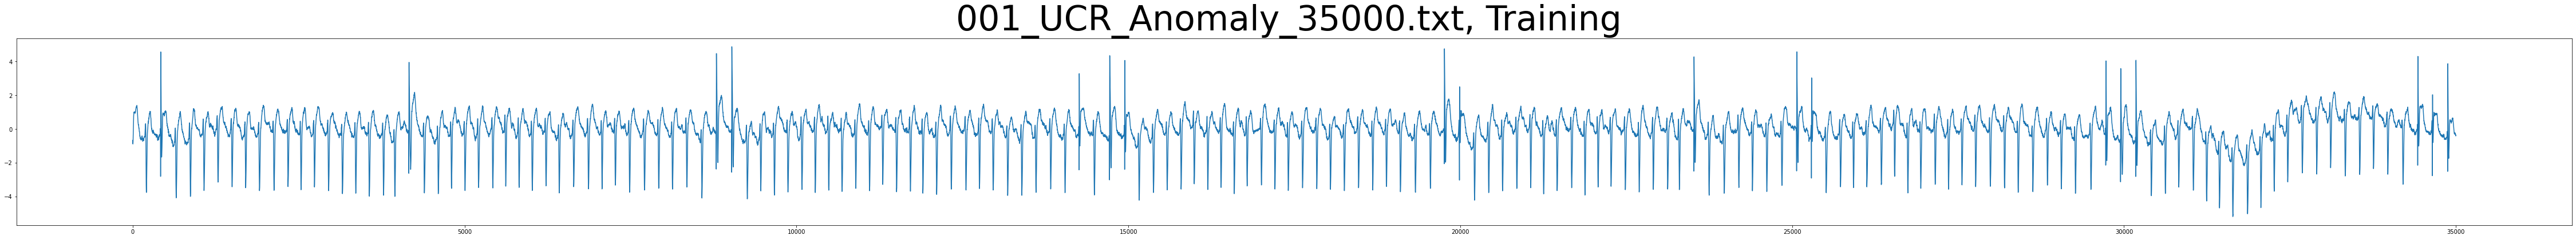

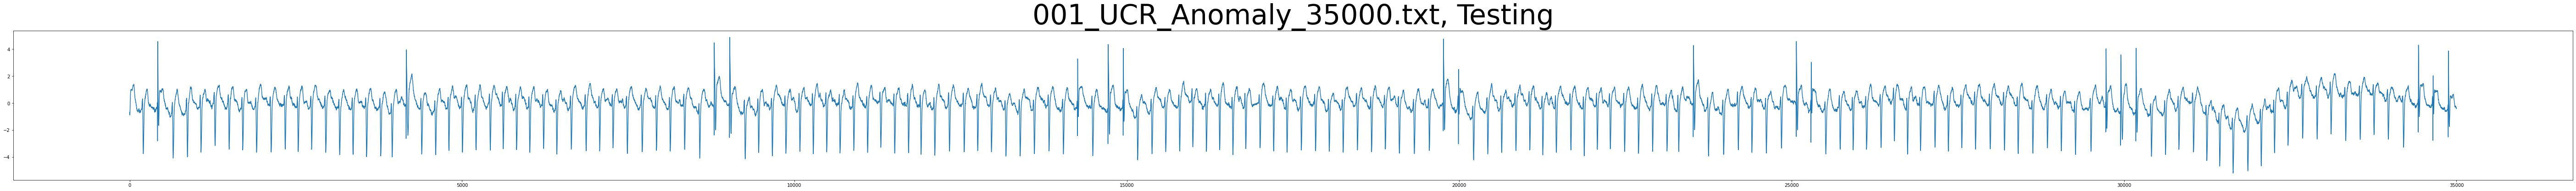

In [23]:
for name, data_df in data_df_list:
    print(f'=== {name} ======================================================')

    # Get data
    _train_df = data_df[data_df['label'] == 'train']['values'].to_frame()
    _test_df = data_df[data_df['label'] == 'test']['values'].to_frame()

    # Normalize data
    _train_df_value = normalize(_train_df)
    _test_df_value = normalize(_test_df)

    # Visualization
    # Plot of train data (without anomaly)
    plotTimeSeries(_train_df_value, title=f'{name}, Training ')
    # Plot of test data (with anomaly)
    plotTimeSeries(_train_df_value, 100, title=f'{name}, Testing')

    # Find autoperiod
    acf(_train_df_value, nlags=max(hints[j]), fft=True)

    # Discretize
    _train_X = createSequences(_train_df_value, )

    # Build model
    model = buildAutoencoder()

    break